## Atomic Force Evaluation and Relaxation

In this notebook, we briefly introduce the atomic force evaluation.

We start by importing all the necessary files and fields to run the scf iteration.

In [1]:
include("../src/Atoms.jl")
include("../src/scfOptions.jl")
include("../src/Ham.jl")
include("../src/hartree_pot_bc.jl")
include("../src/pseudocharge.jl")
include("../src/getocc.jl")
include("../src/anderson_mix.jl")

using PyPlot

/Users/zexu/Library/Python/2.7/lib/python/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
dx = 0.25;
Nunit = 8;
Lat = 10;
# using the default values in Lin's code
YukawaK = 0.0100
n_extra = 10;
epsil0 = 10.0;
T_elec = 100;

kb = 3.1668e-6;
au2K = 315774.67;
Tbeta = au2K / T_elec;


Ndist  = 1;   # Temporary variable
Natoms = round(Integer, Nunit / Ndist);

# Temp var, will be redefined by the size of R later.
R = zeros(Natoms, 1); # this is defined as an 2D array
for j = 1:Natoms
  R[j] = (j-0.5)*Lat*Ndist+dx;
end
# for test purposes
R[1] -= 0.1*Lat*Ndist
R[Natoms] += 0.1*Lat*Ndist

Natoms = size(R)[1];
sigma  = ones(Natoms,1)*(2.0);  # insulator
omega  = ones(Natoms,1)*0.03;
Eqdist = ones(Natoms,1)*10.0;
mass   = ones(Natoms,1)*42000.0;
nocc   = ones(Natoms,1)*2;          # number of electrons per atom
Z      = nocc;
force  = zeros(Natoms, 1);

# creating an atom structure
atoms = Atoms(Natoms, R, sigma,  omega,  Eqdist, mass, Z, nocc, force);

In [3]:
ham = Ham(Lat, Nunit, n_extra, dx, atoms, YukawaK, epsil0, Tbeta)

# total number of occupied orbitals
Nocc = round(Integer, sum(atoms.nocc) / ham.nspin);

# initialize the potentials within the Hemiltonian setting H[\rho_0]
init_pot!(ham, Nocc);

In [4]:
eigOpts = eigOptions();
betamix = 0.5;
mixdim = 10;
mixOpts = andersonMixOptions(ham.Ns, betamix, mixdim );
scfOpts = scfOptions(eigOpts, mixOpts);

In [5]:
scf!(ham, scfOpts)

30-element Array{Float64,1}:
 Inf          
  33.8154     
  14.0379     
   4.13255    
   1.70817    
   1.40805    
   0.886052   
   0.347831   
   0.292222   
   0.436736   
   0.227412   
   0.194972   
   0.113447   
   ⋮          
   0.000236593
   0.000267077
   0.000110063
   5.51655e-5 
   3.08322e-5 
   8.52069e-6 
   3.29172e-6 
   4.22761e-6 
   1.5683e-6  
   2.32283e-7 
   3.02452e-7 
   8.06012e-8 

Once scf iteration is converged, we could see the charge density $\rho$.

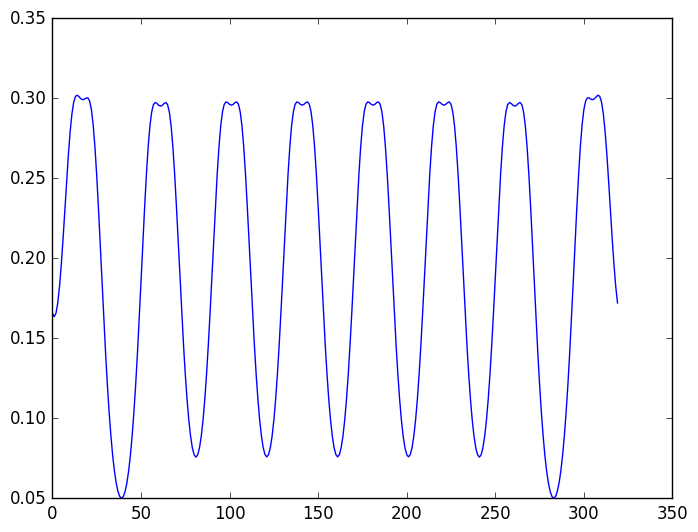

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1205c73d0>

In [6]:
plot(ham.rho)

For the purpose of force calculation, we compute and stored the derivative of pseudocharge in the ham structure.

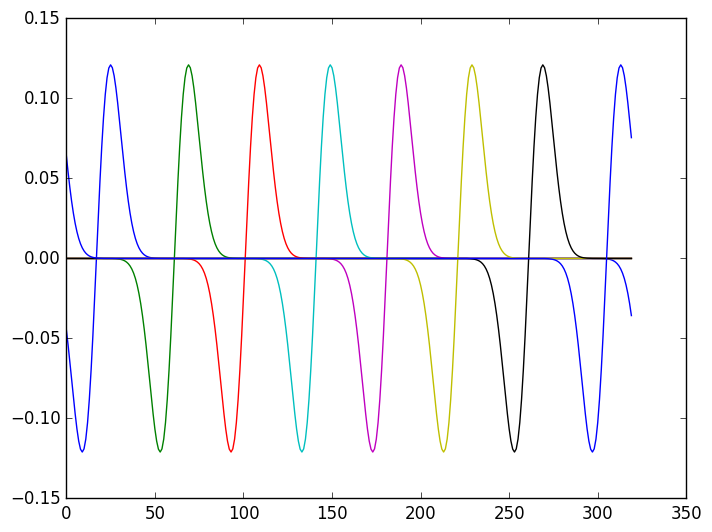

8-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x121073f10>
 PyObject <matplotlib.lines.Line2D object at 0x12107f110>
 PyObject <matplotlib.lines.Line2D object at 0x12107f250>
 PyObject <matplotlib.lines.Line2D object at 0x12107f390>
 PyObject <matplotlib.lines.Line2D object at 0x12107f4d0>
 PyObject <matplotlib.lines.Line2D object at 0x12107f610>
 PyObject <matplotlib.lines.Line2D object at 0x12107f750>
 PyObject <matplotlib.lines.Line2D object at 0x12107f890>

In [7]:
plot(ham.drhoa)

In [8]:
sum(ham.drhoa,1)

1×8 Array{Float64,2}:
 0.0  -3.73709e-17  6.44759e-17  6.44759e-17  …  1.15562e-17  2.77556e-17

In [9]:
size(ham.drhoa)

(320, 8)

In [10]:
ham.atoms.Natoms

8

The total energy of the system is given by ham.Ftot.

In [11]:
ham.Ftot

1.8132049731779274

At this point, the atomic force can be given by the negative of
the first order derivative of $E_{\mathrm{tot}}$ with
respect to the atomic configuration using the Hellmann-Feynman
theorem as

\begin{split}
    F_{I} = -\frac{\partial E_{\mathrm{tot}}(\{R_{I}\})}{\partial
    R_{I}} &= -\int \frac{\partial V_{\mathrm{ion}}}{\partial R_{I}}(r,r';\{R_{I}\})
    P(r',r) \,\mathrm{d}
    r \,\mathrm{d} r' - \frac{\partial E_{\mathrm{II}}(\{R_{I}\})}{\partial
    R_{I}}. \\
    &= -\int \frac{\partial V_{I}}{\partial R_{I}}(r-R_{I})
    ( \rho(r) + \rho_a(r) ) \,\mathrm{d} r ,
\end{split} 

where the $\rho_a(r)$ is stored in the ham structure as ham.rhoa as the pseudocharge. Here we assume the simplest setup where only local pseudopotentials are involved, which makes the double integral localized on its diagonal part so that we can use the charge density instead of the whole density matrix.

The atomic force allows the performance of structural relaxation of the atomic configuration, by minimizing the total energy $E_\text{tot}$ with respect to the atomic positions $\{ R_I \}$. When the atoms are at their equilibrium positions, all atomic forces should be 0.

In [12]:
function get_force!(H::Ham)
    atoms  = H.atoms
    Natoms = atoms.Natoms
    rhotot = H.rho + H.rhoa
    for i=1:Natoms
        # IMPORTANT: derivative is taken w.r.t atom positions, which introduces the minus sign
        dV = -hartree_pot_bc_opt_vec(H.drhoa[:,i], H.Ls, H.YukawaK, H.epsil0) 
        # Force is negative gradient
        atoms.force[i] = - sum(dV.*rhotot)*H.dx
    end
end

get_force! (generic function with 1 method)

In [13]:
get_force!(ham)
ham.atoms.force

8×1 Array{Float64,2}:
  0.0249584 
 -0.00293892
  4.74362e-6
  1.16715e-6
 -1.16505e-6
 -4.74692e-6
  0.00293891
 -0.0249584 

In the example, the atomic positions are away from their equilibrium positions, specifically for the first atom and the very last one. For sanity check, we do the integration by parts here to show the calculation is correct.

In [14]:
sum(ham.Vhar.*ham.drhoa[:,1])*ham.dx

0.024958443392998405

In [15]:
dV = -hartree_pot_bc_opt_vec(ham.drhoa[:,1], ham.Ls, ham.YukawaK, ham.epsil0)
sum(dV.*(ham.rho+ham.rhoa))*ham.dx

-0.024958443392998395

## Atomic relaxation

As discussed above, once the atomic force evaluation is done, we could solve the so-called geometry optimization problem to find the equilibrium positions for the atoms.

Here, we use the the NLopt module for Julia. For more details of the module, visit https://github.com/JuliaOpt/NLopt.jl.

In [16]:
using NLopt

To call the optimization routine in NLopt, one need to wrap up the target function as a function in this format:
```julia
function myfunc(x::Vector, grad::Vector)
    ## update grad before returning function value
    return 
end    
```
Since we have the scf iteration routine and force calculations ready, one just need to wrap it up as the following.

In [17]:
function run_scf!(R2::Array{Float64,1}, H::Ham=ham)
    
    ## The default setup is to keep the first atom fixed to break the symmetry.
    
    R = H.atoms.R
    R[2:end] = R2
    
    H.atoms.R = R

    ## It is very important to re-initialize the potential and update the pseudocharge
    ## in order to restart the scf iteration.
    init_pot!(H, Nocc);
     
    update_rhoa!(H);
    
    eigOpts = eigOptions();
    betamix = 0.5;
    mixdim = 10;
    mixOpts = andersonMixOptions(H.Ns, betamix, mixdim );
    scfOpts = scfOptions(eigOpts, mixOpts);
    
    scf!(H, scfOpts)
    get_force!(H)
end 

run_scf! (generic function with 2 methods)

In [18]:
ham.atoms.R

8×1 Array{Float64,2}:
  4.25
 15.25
 25.25
 35.25
 45.25
 55.25
 65.25
 76.25

In [20]:
ham.atoms.force

8×1 Array{Float64,2}:
  0.0249584 
 -0.00293892
  4.74362e-6
  1.16715e-6
 -1.16505e-6
 -4.74692e-6
  0.00293891
 -0.0249584 

We call the run_scf! routine once by updating the position of the very last atom.

In [22]:
R2 = R[2:end]
R2[end] = 75.25

75.25

In [23]:
run_scf!(R2, ham)

In [24]:
ham.atoms.R

8×1 Array{Float64,2}:
  4.25
 15.25
 25.25
 35.25
 45.25
 55.25
 65.25
 75.25

In [25]:
ham.atoms.force

8×1 Array{Float64,2}:
  0.0098806 
 -0.00293539
  6.42739e-6
  1.87548e-6
  8.52839e-7
  2.44974e-6
  4.77433e-6
 -0.00696159

Here we can build the optimization target function, with the update of ham structure within every call. Ham structure is inputted as a default global variable for now.

In [30]:
function optfunc_f!(R2::Array{Float64,1}, grad::Array{Float64,1}, H::Ham=ham)
    run_scf!(R2, H)
    grad[:] = -H.atoms.force[2:end]
    return H.Ftot
end

optfunc_f! (generic function with 2 methods)

In NLopt, the key structure is called Opt. We create an Opt object which encapsulates the dimensionality of your problem (here, Natoms - 1) and the algorithm to be used (here, LD_LBFGS) and use various functions to specify the constraints and stopping criteria (along with any other aspects of the problem).

In [31]:
opt = Opt(:LD_LBFGS, ham.atoms.Natoms - 1)
xtol_rel!(opt,1e-4)

## We are minimizing the function value
min_objective!(opt, optfunc_f!)

Again, for sanity check, we call the optimization routine with the start point as an minimum.

In [32]:
R0 = ham.atoms.R
R0 = R0[2:end] - 1.0

7-element Array{Float64,1}:
 14.25
 24.25
 34.25
 44.25
 54.25
 64.25
 74.25

In [33]:
(minf,minx,ret) = optimize(opt, R0)
# println("got $minf at $minx after $count iterations (returned $ret)")

(1.7932419739286838, [14.25, 24.25, 34.25, 44.25, 54.25, 64.25, 74.25], :SUCCESS)

By adding random noise on the initial value of atomic position, we show that the atomic relaxation is realized.

In [35]:
R0 = R0 + 0.03 * randn(ham.atoms.Natoms - 1)

7-element Array{Float64,1}:
 14.2429
 24.2197
 34.2478
 44.2532
 54.2665
 64.2293
 74.2239

In [37]:
opt = Opt(:LD_LBFGS, ham.atoms.Natoms - 1)
xtol_rel!(opt,1e-4)
min_objective!(opt, optfunc_f!)
(minf,minx,ret) = optimize(opt, R0)
# println("got $minf at $minx after $count iterations (returned $ret)")

(1.7932420489547565, [14.2492, 24.2477, 34.2473, 44.2461, 54.2465, 64.2475, 74.2486], :XTOL_REACHED)

In [39]:
ham.atoms.R

8×1 Array{Float64,2}:
  4.25  
 14.2492
 24.2477
 34.2473
 44.2461
 54.2465
 64.2475
 74.2486

In [40]:
ham.atoms.force

8×1 Array{Float64,2}:
 -9.50512e-6
 -3.33151e-6
  5.34069e-6
 -4.09309e-6
  7.43058e-6
  2.5969e-6 
  4.43344e-7
  1.1182e-6 

In [ ]:
plot(ham.rho)